In [1]:
import ast
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

# All Trials

Some of the best models found on the subset...:  
  * $0.176$ cnn	adam	0.01	20	20	[0]	2	[64, 32, 16]	[(4, 2, 0), (3, 1, 0), (3, 2, 0)]  
  * $0.163$ cnn	adam	0.01	10	20	[0]	10	[10, 10, 10]	[(8, 1, 0), (5, 1, 0), (3, 2, 0)]

In [2]:
a = np.array([10, 5, 2, 1])
a[:-1]

array([10,  5,  2])

In [10]:
full = pd.read_csv('/s/chopin/l/grad/stock/data/results-epochs-fcn/overview/results.csv', index_col=[0])
full.error_trace = full.error_trace.map(lambda x: ast.literal_eval(x))
full.head(10)

,world_size,model,algo,rho,epochs,batch_size,channels,latent_dim,hidden_dims,ker_str_pad,error_trace,time_data_trace,time_step_trace,duration
0,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[512, 128, 64, 32, 16, 3]",[],"[0.6798381805419922, 0.6458194851875305, 0.618...","[42.841588497161865, 0.0036568641662597656, 0....","[43.11160731315613, 0.2538933753967285, 0.3891...",2528.383649
1,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[512, 128, 32, 8, 3]",[],"[0.6788201332092285, 0.6379746794700623, 0.596...","[46.62919998168945, 0.009081363677978516, 0.00...","[47.884825706481934, 0.3005056381225586, 0.283...",2678.696340
2,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[256, 128, 64, 16, 3]",[],"[0.6843791007995605, 0.6661966443061829, 0.657...","[43.126564025878906, 0.4303863048553467, 0.003...","[44.239344120025635, 0.6617982387542725, 0.256...",2548.740829
3,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[256, 64, 16, 3]",[],"[0.6833799481391907, 0.6614023447036743, 0.643...","[44.07996463775635, 0.0019276142120361328, 0.0...","[45.471675872802734, 0.170121431350708, 0.1700...",2534.921186
4,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[128, 32, 16, 8, 3]",[],"[0.6830209493637085, 0.6665421724319458, 0.664...","[44.33112716674805, 0.002119302749633789, 0.13...","[45.62153911590576, 0.21773433685302734, 0.219...",2500.452343
5,6,lin,adam,0.001,10,512,"[0, 1, 2]",3,"[64, 16, 4, 3]",[],"[0.6919019818305969, 0.6802234649658203, 0.682...","[44.545201778411865, 0.002900362014770508, 0.0...","[45.588122606277466, 0.19808244705200195, 0.17...",2488.353964


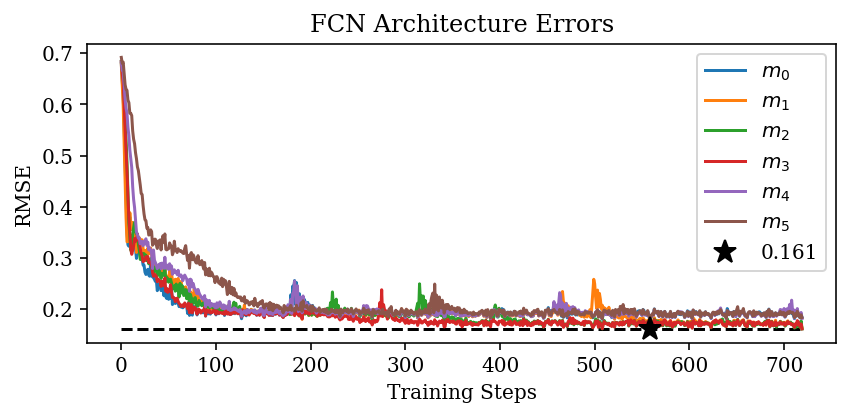

In [17]:
top = 1
max_len = 0

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)

for i, row in full.iterrows():
    error = row.error_trace
    ax.plot(error, label=f'$m_{i}$')
    
    top_index_temp = np.argmin(error)
    top_temp = error[top_index_temp]
    if top_temp < top:
        top = top_temp
        top_index = top_index_temp    
    max_len = max(max_len, len(error))

#! plot the model with the lowest _observed_ error
ax.hlines(top, 0, max_len - 1, linestyle='dashed')
ax.plot(top_index, top, 'k*', markersize=12, label=f'{top:.3f}')

plt.legend();
ax.set_xlabel('Training Steps')
ax.set_ylabel('RMSE')
ax.set_title('FCN Architecture Errors')
plt.tight_layout()
fig.savefig('/s/chopin/l/grad/stock/data/media/rmse-loss-fcn.pdf', dpi=600);

In [12]:
results = pd.read_csv('/s/chopin/l/grad/stock/data/results-epochs-cnn/overview/results.csv', index_col=[0])
results.error_trace = results.error_trace.map(lambda x: ast.literal_eval(x))
results.head(10)

,world_size,model,algo,rho,epochs,batch_size,channels,latent_dim,hidden_dims,ker_str_pad,error_trace,time_data_trace,time_step_trace,duration
0,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[4, 8, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.6006556749343872, 0.5837854146957397, 0.575...","[39.7069730758667, 0.0033566951751708984, 0.00...","[40.247307538986206, 0.7128505706787109, 0.505...",2593.634655
1,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[4, 8, 10]","[(4, 1, 0), (5, 2, 0), (3, 2, 0)]","[0.6883633136749268, 0.671728789806366, 0.6679...","[40.352893114089966, 0.05185556411743164, 0.00...","[44.92036986351013, 0.7463982105255127, 0.4921...",2611.156265
2,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[4, 8, 10]","[(5, 1, 0), (4, 2, 0), (3, 1, 0)]","[0.819965124130249, 0.7993359565734863, 0.8017...","[40.26626467704773, 0.1389155387878418, 0.0041...","[44.43829393386841, 0.8501803874969482, 0.5974...",2575.203101
3,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8138905763626099, 0.7805935144424438, 0.769...","[38.31879019737244, 0.0045735836029052734, 0.0...","[43.088722944259644, 0.9528131484985352, 0.881...",2553.686213
4,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[10, 10, 10]","[(4, 1, 0), (5, 2, 0), (3, 2, 0)]","[0.7198356986045837, 0.6818752884864807, 0.659...","[39.32677865028381, 0.0042607784271240234, 0.0...","[43.662718057632446, 0.9715666770935059, 1.028...",2558.539600
5,6,cnn,adam,0.001,10,512,"[0, 1, 2]",3,"[10, 10, 10]","[(5, 1, 0), (4, 2, 0), (3, 1, 0)]","[0.7850107550621033, 0.7496523261070251, 0.728...","[39.494549036026, 0.003729581832885742, 0.0028...","[44.49362254142761, 1.1892473697662354, 1.1046...",2611.951916


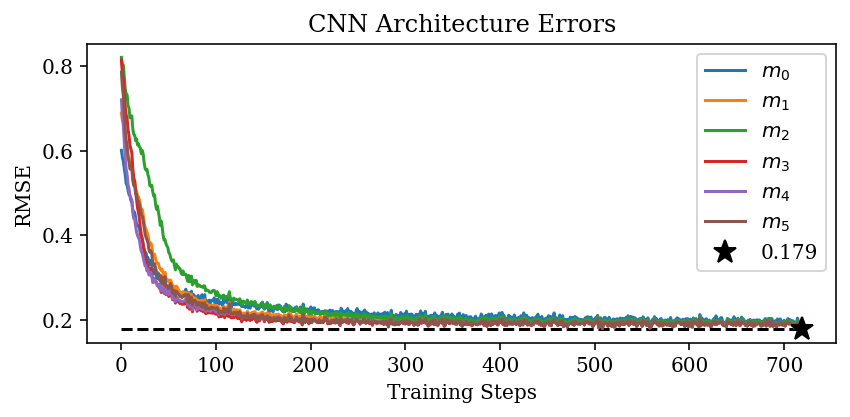

In [16]:
top = 1
max_len = 0

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)

for i, row in results.iterrows():
    error = row.error_trace
    ax.plot(error, label=f'$m_{i}$')
    
    top_index_temp = np.argmin(error)
    top_temp = error[top_index_temp]
    if top_temp < top:
        top = top_temp
        top_index = top_index_temp    
    max_len = max(max_len, len(error))

#! plot the model with the lowest _observed_ error
ax.hlines(top, 0, max_len - 1, linestyle='dashed')
ax.plot(top_index, top, 'k*', markersize=12, label=f'{top:.3f}')

plt.legend();
ax.set_xlabel('Training Steps')
ax.set_ylabel('RMSE')
ax.set_title('CNN Architecture Errors')
plt.tight_layout()
fig.savefig('/s/chopin/l/grad/stock/data/media/rmse-loss-cnn.pdf', dpi=600);

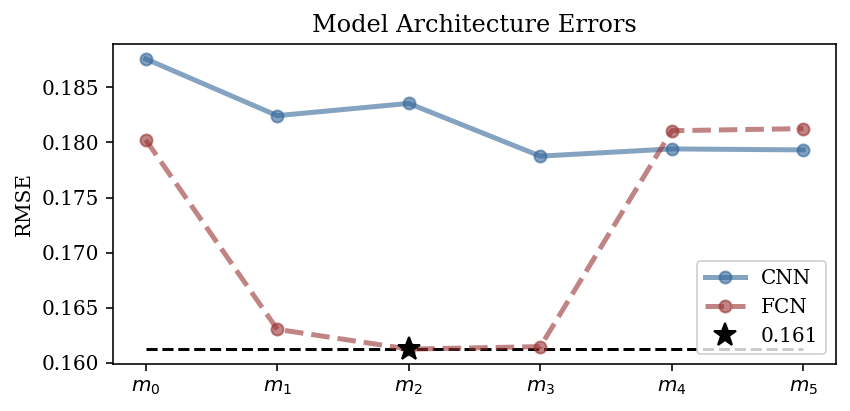

In [15]:
top = 1

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
cnn_mins = []
full_mins = []
labels = [f'$m_{i}$' for i in range(len(results))]

for i, row in results.iterrows():
    error = row.error_trace
    m = min(error)
    cnn_mins.append(m)
    if m < top:
        top = m
        top_index = i
        
for i, row in full.iterrows():
    error = row.error_trace
    m = min(error)
    full_mins.append(m)
    if m < top:
        top = m
        top_index = i

ax.plot(cnn_mins, 'o-', lw=2.5, color=(0.2, 0.4, 0.6, 0.6), label='CNN')
ax.plot(full_mins, 'o--', lw=2.5, color=(0.6, 0.2, 0.2, 0.6), label='FCN')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

#! plot the model with the lowest _observed_ error
ax.hlines(top, 0, len(cnn_mins) - 1, linestyle='dashed')
ax.plot(top_index, top, 'k*', markersize=12, label=f'{top:.3f}')

plt.legend();
ax.set_ylabel('RMSE')
ax.set_title('Model Architecture Errors')
plt.tight_layout()
fig.savefig('/s/chopin/l/grad/stock/data/media/rmse-loss-min.png', dpi=600);

In [19]:
cnn_channels = pd.read_csv('/s/chopin/l/grad/stock/data/results-channels-cnn/overview/results.csv', index_col=[0])
cnn_channels.error_trace = cnn_channels.error_trace.map(lambda x: ast.literal_eval(x))
cnn_channels.head(10)

,world_size,model,algo,rho,epochs,batch_size,channels,latent_dim,hidden_dims,ker_str_pad,error_trace,time_data_trace,time_step_trace,duration
0,6,cnn,adam,0.001,8,512,[0],3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.7553728818893433, 0.714765191078186, 0.6889...","[39.213650703430176, 0.09689831733703613, 0.21...","[44.02460265159607, 1.030587911605835, 0.96154...",2055.051059
1,6,cnn,adam,0.001,8,512,"[2, 12]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.6920448541641235, 0.6504760980606079, 0.620...","[43.97013211250305, 0.14467263221740723, 0.258...","[46.370970249176025, 1.1488444805145264, 1.077...",2088.964882
2,6,cnn,adam,0.001,8,512,"[0, 1, 2]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.7717787623405457, 0.7387104034423828, 0.723...","[44.685569763183594, 0.004462003707885742, 0.0...","[48.457942962646484, 0.9436357021331787, 0.958...",2078.818646
3,6,cnn,adam,0.001,8,512,"[0, 4, 7, 10]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.9163029789924622, 0.878108561038971, 0.8562...","[44.238959550857544, 0.08615565299987793, 0.04...","[47.217254400253296, 1.0086274147033691, 0.941...",2083.977479
4,6,cnn,adam,0.001,8,512,"[7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8180067539215088, 0.7745888829231262, 0.737...","[44.04124093055725, 0.1308588981628418, 0.0774...","[47.32128882408142, 0.9315745830535889, 0.9198...",2056.648842
5,6,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8509116768836975, 0.8165431618690491, 0.795...","[39.91592860221863, 0.002607583999633789, 0.00...","[41.04271912574768, 0.9096400737762451, 0.8581...",2052.633446
6,6,cnn,adam,0.001,8,512,"[1, 7, 12]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8513764142990112, 0.8165228962898254, 0.796...","[42.24688243865967, 0.1792445182800293, 0.0029...","[43.59005856513977, 1.1003916263580322, 1.0045...",2042.509679


# Best Model

In [8]:
best = pd.read_csv('../results/overview/best_result.csv', names=['attr','val'])
best.head(len(best))

,attr,val
0,model,cnn
1,algo,adam
2,rho,0.01
3,epochs,25
4,batch_size,32
5,channels,[0]
6,latent_dim,3
7,hidden_dims,"[10, 10, 10]"
8,ker_str_pad,"[(8, 1, 0), (5, 1, 0), (3, 2, 0)]"
9,error_trace,"[0.27523937821388245, 0.2520464360713959, 0.21..."


# Latent Vector of Best Model

In [18]:
latent = pd.read_csv('/s/chopin/l/grad/stock/data/results/experiment-5/latent_vectors.csv', index_col=[0])
latent.latent_vector = latent.latent_vector.map(lambda x: ast.literal_eval(x))
#! only look at the first _n_ samples
latent = latent.iloc[:5000]
length = len(latent.latent_vector[0])
print(f'>> {length} dimensional latent space with {len(latent)} samples!')
latent.head()

>> 3 dimensional latent space with 5000 samples!


,filename,label,latent_vector
0,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,7,"[0.40135428, 0.0666444, -0.27181438]"
1,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,3,"[-0.4999366, -1.3922496, -0.538147]"
2,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,0,"[1.1789136, 1.0638875, 0.72371215]"
3,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,6,"[-3.0594385, -3.402099, -2.1573548]"
4,/s/chopin/l/grad/stock/data/eastpac2_20x20/eas...,3,"[0.017623752, -0.5566914, -0.93026465]"


**NOTES**: plot the latent space in the respective dimension.  
  * 2 dimensions 
  * 3 dimensions at four different angles
  * N dimensions reduced to 2 with PCA and tSNE

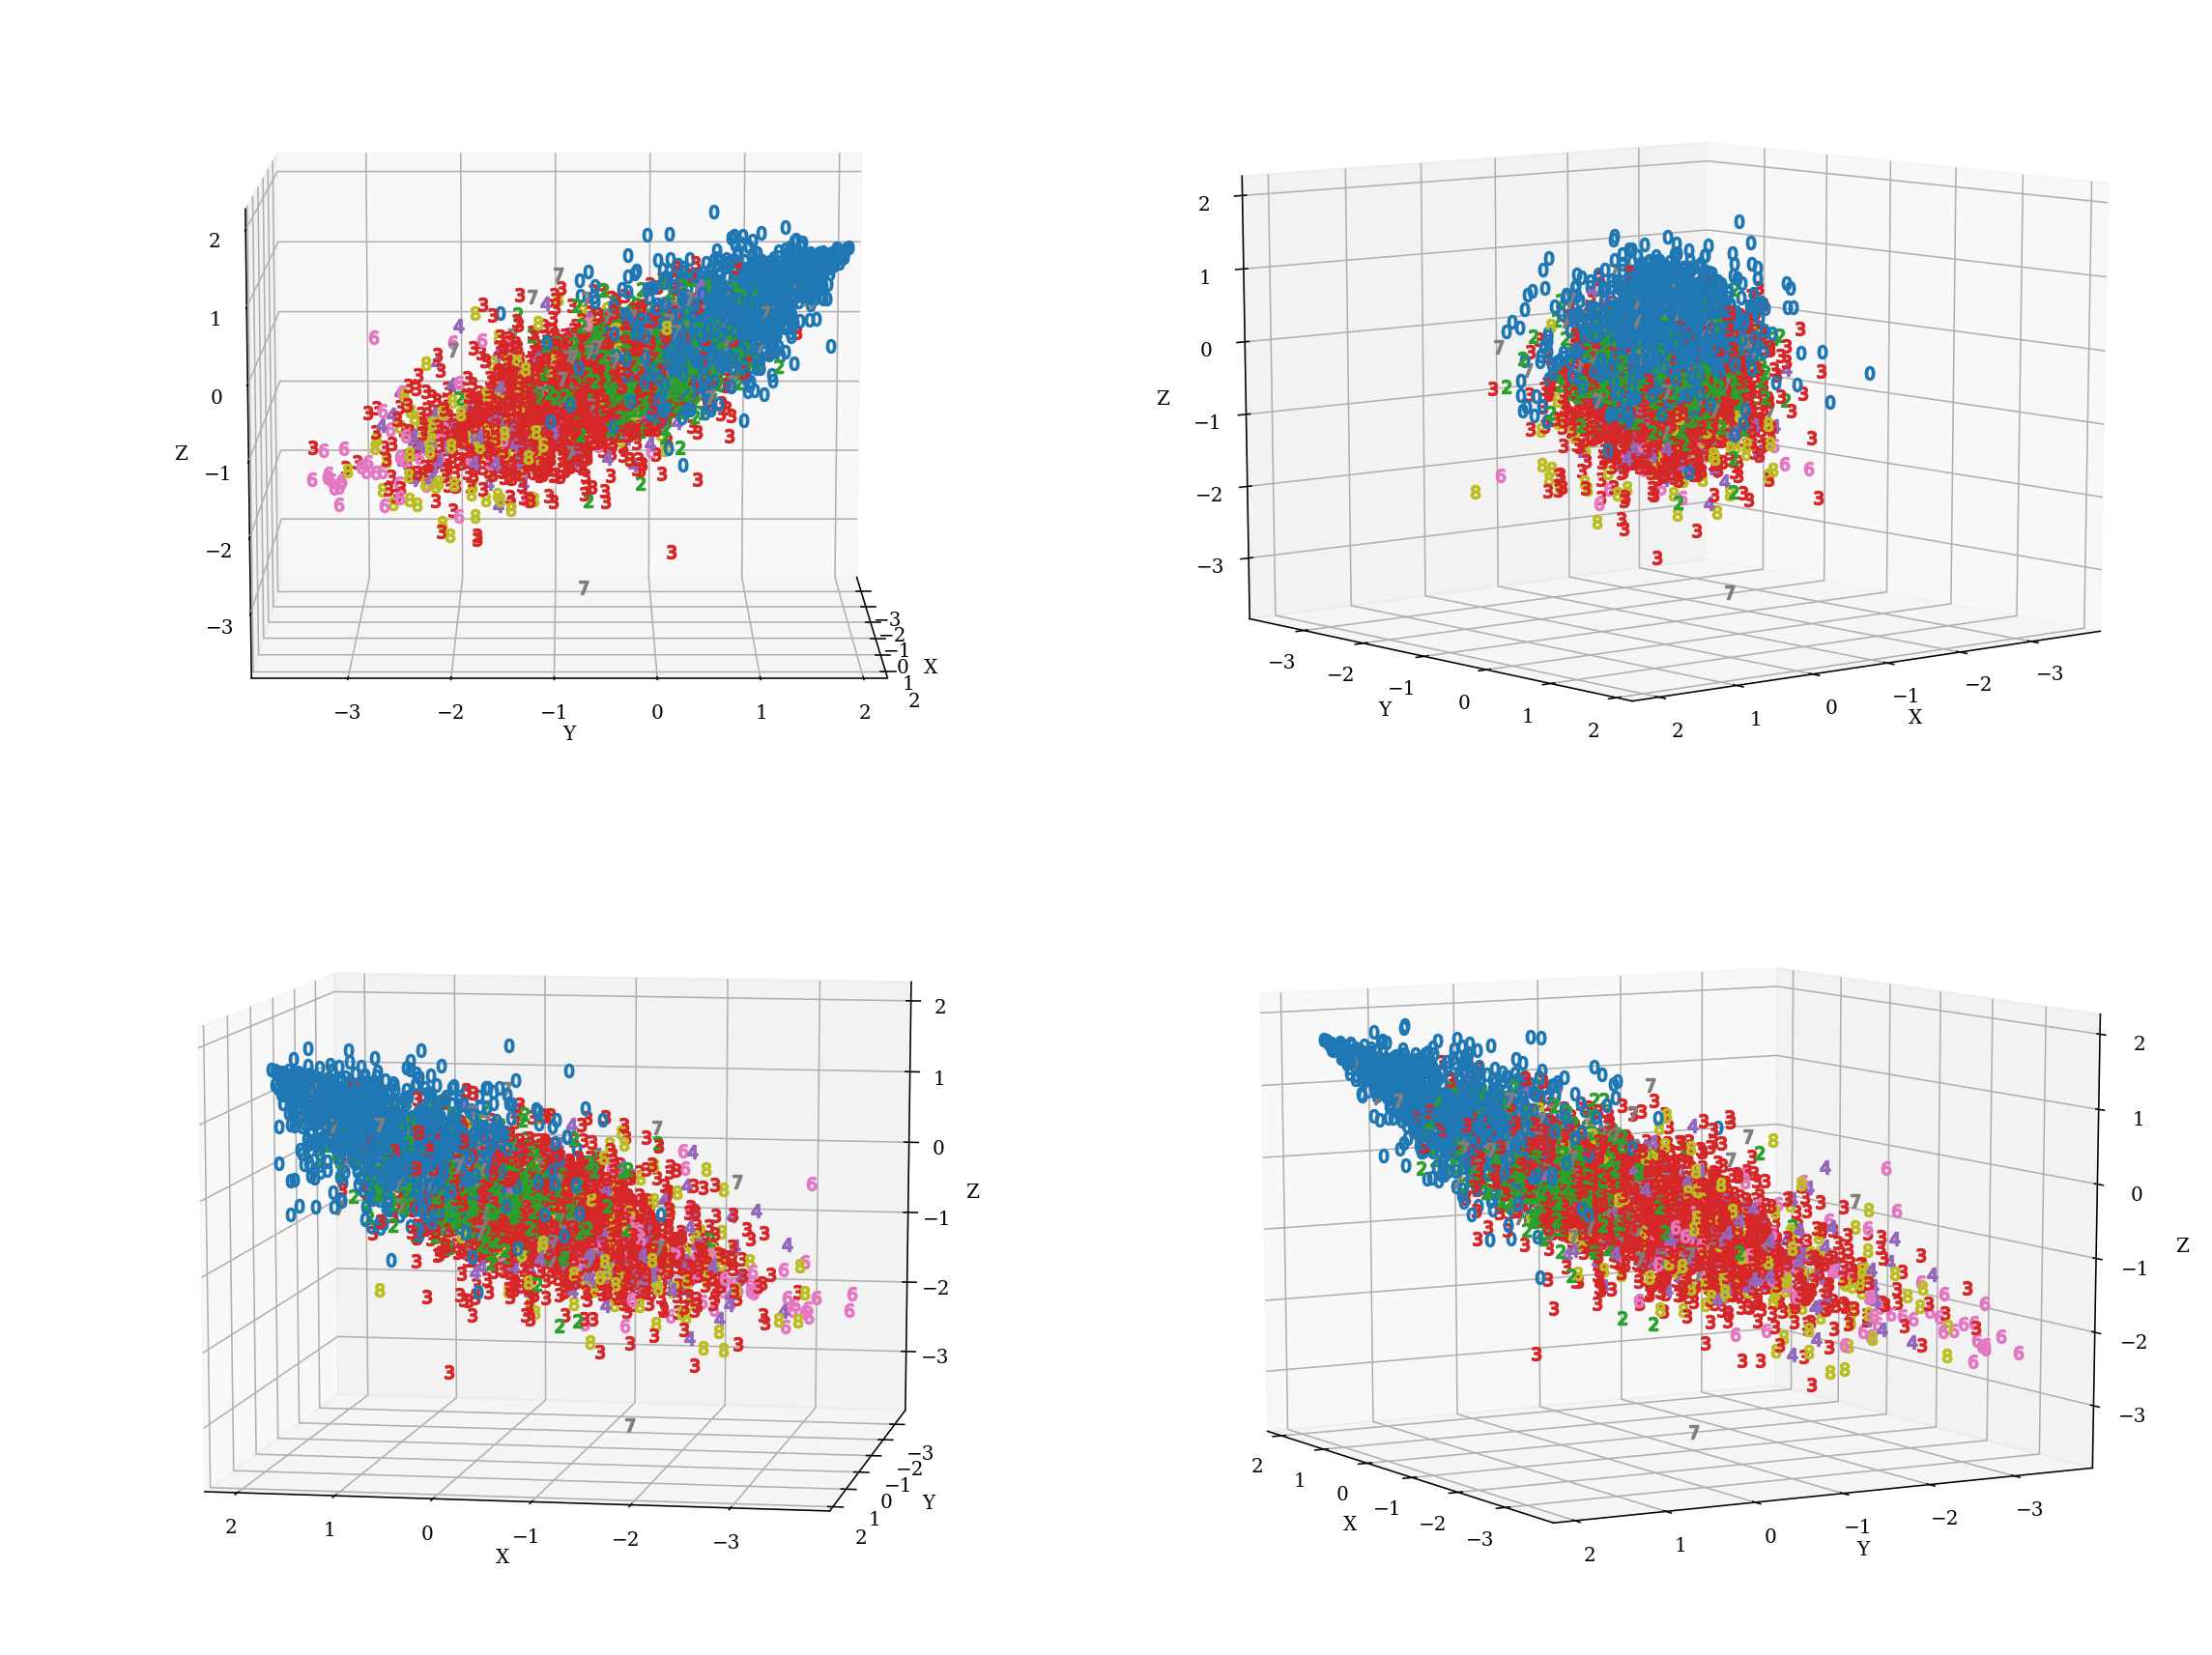

In [19]:
%matplotlib inline

# if more than 10 colors are needed, use Set3.
# COLORS = pl.cm.Set3(np.linspace(0, 1, 12))
COLORS = pl.cm.tab10(np.linspace(0, 1, 10))


#! 2D plot of latent space by labels
if length == 2:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    
    for i, row in latent.iterrows():
        ax.plot(row.latent_vector[0], row.latent_vector[1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

#! 3D plot of latent space by labels
elif length == 3:
    
    fig = plt.figure(figsize=(16, 12))

    for itr in range(4):
        ax = fig.add_subplot(2, 2, itr+1, projection='3d')

        for i, row in latent.iterrows():
            ax.scatter(row.latent_vector[0], row.latent_vector[1], row.latent_vector[2],
                       marker='${}$'.format(row.label), s=45, c=[COLORS[row.label]])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        ax.view_init(elev=10., azim=itr*50)

    plt.tight_layout()
    plt.show()

#! ND plot of latent space by labels using PCA and tSNE dim reduction
else:
    
    X = np.stack(latent.latent_vector, axis=0)
    # the output of the NN is normalized using nn.BatchNorm1d()
    # however, we could also standardize with a mean of 0 and std of 1.
    # X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    components = PCA(n_components=2).fit_transform(X)
    embeded = TSNE(n_components=2).fit_transform(X)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 2, 1)

    for i, row in latent.iterrows():
        ax.plot(components[i, 0], components[i, 1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('PCA')

    ax = fig.add_subplot(1, 2, 2)

    for i, row in latent.iterrows():
        ax.plot(embeded[i, 0], embeded[i, 1], 
                marker='${}$'.format(row.label), c=COLORS[row.label])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('tSNE')

    plt.show()

## Interactive 3D plot 

In [7]:
if length == 3:
    
    %matplotlib notebook

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, row in latent.iterrows():
        ax.scatter(row.latent_vector[0], row.latent_vector[1], row.latent_vector[2],
                   marker='${}$'.format(row.label), s=45, c=[COLORS[row.label]])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Node Timings

In [20]:
nodes = pd.read_csv('/s/chopin/l/grad/stock/data/results-nodes/results.csv', index_col=[0])
nodes.time_data_trace = nodes.time_data_trace.map(lambda x: ast.literal_eval(x))
nodes.time_step_trace = nodes.time_step_trace.map(lambda x: ast.literal_eval(x))
nodes.head(10)

,world_size,n_batches,model,algo,rho,epochs,batch_size,channels,latent_dim,hidden_dims,ker_str_pad,error_trace,time_data_trace,time_step_trace,duration
0,6,72,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8509116768836975, 0.8165431618690491, 0.795...","[39.91592860221863, 0.002607583999633789, 0.00...","[41.04271912574768, 0.9096400737762451, 0.8581...",2052.633446
1,5,86,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.856793224811554, 0.8164132237434387, 0.7899...","[41.249470233917236, 0.0037093162536621094, 0....","[43.949373722076416, 0.9535164833068848, 1.131...",2521.699583
2,4,108,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8483720421791077, 0.8169186115264893, 0.787...","[36.1352801322937, 0.002191305160522461, 0.004...","[37.14125680923462, 0.8662877082824707, 0.9526...",2717.216910
3,3,144,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8556541204452515, 0.8171835541725159, 0.784...","[27.003756999969482, 0.07874751091003418, 0.06...","[28.237321376800537, 0.9688704013824463, 0.754...",2793.527684
4,2,215,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8532774448394775, 0.816789448261261, 0.7861...","[14.526196241378784, 0.010772228240966797, 0.0...","[16.228927612304688, 0.8270668983459473, 0.865...",2646.646443
5,1,530,cnn,adam,0.001,8,512,"[0, 1, 2, 7, 8, 9]",3,"[10, 10, 10]","[(3, 1, 0), (4, 2, 0), (4, 2, 0)]","[0.8525632619857788, 0.8188525438308716, 0.790...","[8.371729850769043, 0.004770040512084961, 0.00...","[9.012966632843018, 0.7806754112243652, 0.7270...",3866.038977


576
688
864
1152
1720
3440
[21.13487052 23.59210652 28.75264984 16.52791428  4.1352061  29.63432398]
[34.19427759 42.00890814 45.25891635 46.52193139 44.06123287 64.02440476]
[34.21055743 42.02832638 45.2869485  46.55879473 44.11077405 64.43398296]


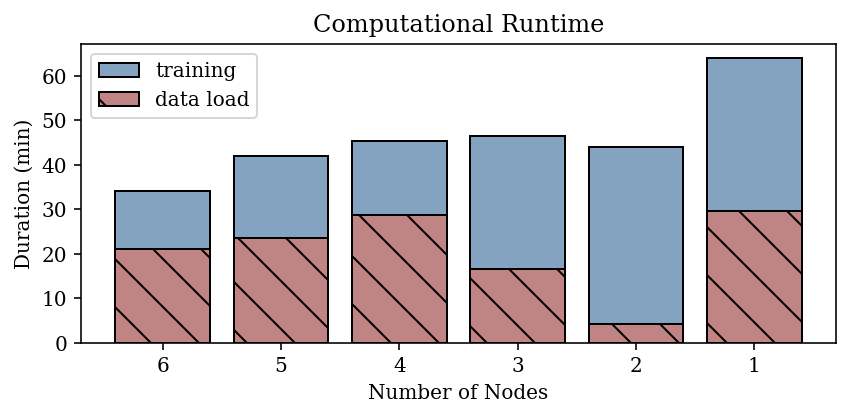

In [21]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)

l_load_time = np.zeros(len(nodes))
l_step_time = np.zeros(len(nodes))
l_duration  = np.zeros(len(nodes))
ids = len(nodes) 
for i in range(ids):
    s = nodes.iloc[i]
    l_load_time[i] = np.sum(s.time_data_trace) / 60
    l_step_time[i] = np.sum(s.time_step_trace) / 60
    l_duration[i] = s.duration / 60
    print(len(s.time_data_trace))

print(l_load_time)
print(l_step_time)
print(l_duration)

rects1 = ax.bar(range(ids), l_load_time, color=(0.6, 0.2, 0.2, 0.6), hatch='\\', edgecolor='black')
rects2 = ax.bar(range(ids), l_step_time - l_load_time, bottom=l_load_time, 
                color=(0.2, 0.4, 0.6, 0.6), edgecolor='black')

ax.set_xlabel('Number of Nodes')
ax.set_ylabel('Duration (min)')
ax.set_xticks(range(ids))
ax.set_xticklabels( np.arange(1, 7)[::-1])
ax.set_title('Computational Runtime')
ax.legend( (rects2[0], rects1[0]), ('training', 'data load') )
plt.tight_layout()
fig.savefig('/s/chopin/l/grad/stock/data/media/node-duration.png', dpi=600);

# Output Images

# Model Arch

In [23]:
import sys
sys.path.append('../src')
import models

In [26]:
    if 'cnn' in args.model:
        return ColvolutionalAutoencoder(X_shape, args.latent_dim,
                                        args.hidden_dims, args.ker_str_pad)
    
args['model'] = 'a'
args['latent_dim'] = 3
args['hidden_dims'] = [10, 10, 10]
args['ker_str_pad'] = [(3, 1, 0), (4, 2, 0), (4, 2, 0)]
nnet = models.get_model([3, 20, 20], args)

SyntaxError: 'return' outside function (<ipython-input-26-c21a79c120d7>, line 2)